## Simple Linear Regression

Textbook Chapter 15

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

### Correlation

Recreate the 4 correlation plots in slides (Normally this wouldn't be in the notebook, but it might be of interest to you.)

Note: We use `np.corrcoef` to compute the correlation coefficient $r$, though we could also compute manually too.

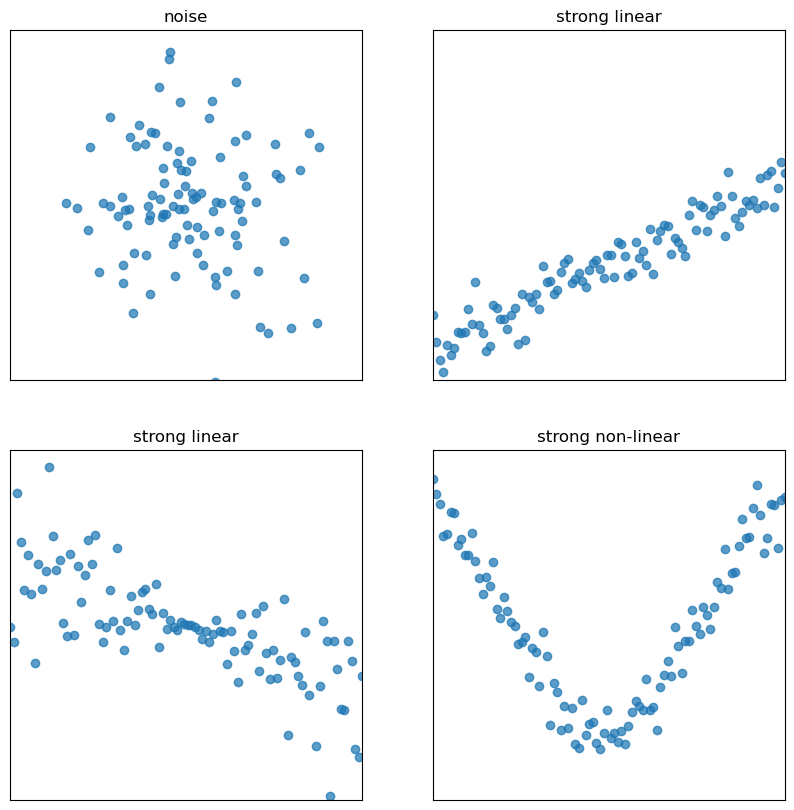

[-0.12066459676011669, 0.9508258477335819, -0.7230212909978788, 0.056355714456301234]


In [2]:
# Set random seed recreate same random points as slides
np.random.seed(43)
plt.style.use('default') # Revert style to default mpl

def plot_and_get_corr(ax, x, y, title):
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x, y, alpha = 0.73)
    ax.set_title(title)
    return np.corrcoef(x, y)[0, 1]

fig, axs = plt.subplots(2, 2, figsize = (10, 10))

# Just noise
x1, y1 = np.random.randn(2, 100)
corr1 = plot_and_get_corr(axs[0, 0], x1, y1, title = "noise")

# Strong linear
x2 = np.linspace(-3, 3, 100)
y2 = x2 * 0.5 - 1 + np.random.randn(100) * 0.3
corr2 = plot_and_get_corr(axs[0, 1], x2, y2, title = "strong linear")

# Unequal spread
x3 = np.linspace(-3, 3, 100)
y3 = - x3/3 + np.random.randn(100)*(x3)/2.5
corr3 = plot_and_get_corr(axs[1, 0], x3, y3, title = "strong linear")
extent = axs[1, 0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Strong non-linear
x4 = np.linspace(-3, 3, 100)
y4 = 2*np.sin(x3 - 1.5) + np.random.randn(100) * 0.3
corr4 = plot_and_get_corr(axs[1, 1], x4, y4, title = "strong non-linear")

plt.show()
print([corr1, corr2, corr3, corr4])

## Simple Linear Regression

First, let's implement the tools we'll need for regression.

In [3]:
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    correlation_coefficient=np.mean(np.std(x)/np.std(y))
    return correlation_coefficient

In [4]:
def slope(x, y):
    r = np.corrcoef(x,y)[0,1]
    slop_value = r*(np.std(y)/np.std(x))
    return slop_value

def intercept(x, y):
    m= slope(x,y)
    intercept_value = np.mean(y)-m*np.mean(x)
    return intercept_value

# Evaluating the Model

In [5]:
# Helper functions
def fit_least_squares(x, y):
    r = np.corrcoef(x,y)[0,1]
    theta_1 = r*(np.std(y)/np.std(x))
    theta_0 = np.mean(y)-theta_1*np.mean(x)
    return theta_1,theta_0

def predict(x, theta_0, theta_1):
    y_pred = theta_0+theta_1*x
    return y_pred

def compute_mse(y, yhat):
    n = len(y)
    mse = np.sum((y-yhat)**2)/n
    return mse

Below we define `least_squares_evaluation` which:
* Computes general data statistics like mean, standard deviation, and linear correlation $r$
* Fits least squares to data of the form $(x, y)$
* Computes performance metrics like RMSE
* Plots two visualizations:
    * Original scatter plot with fitted line
    * Residual plot

In [6]:
plt.style.use('default') # Revert style to default mpl
NO_VIZ, RESID, RESID_SCATTER = range(3)
def least_squares_evaluation(x, y, visualize = NO_VIZ):
    theta_0, theta_1 = fit_least_squares(x, y)
    yhat = predict(x, theta_0, theta_1)

    # Statistics Performance metrics
    if visualize == NO_VIZ:
        print(f"x_mean : {np.mean(x):.2f}, y_mean : {np.mean(y):.2f}")
        print(f"x_stdev: {np.std(x):.2f}, y_stdev: {np.std(y):.2f}")
        print(f"r = Correlation(x, y): {correlation(x, y):.3f}")
        print(f"theta_0: {theta_0:.2f}, theta_1: {theta_1:.2f}")
        print(f"RMSE: {np.sqrt(compute_mse(y, yhat)):.3f}")

    # Visualization
    fig, axs = None, None
    if visualize == RESID:
        fig = plt.figure(figsize = (4, 3))
        plt.scatter(x, y - yhat, color = 'red')
        plt.axhline(y = 0, xmin = 0, xmax = 500)
        fig.axes[0].set_title("Residuals")


    if visualize == RESID_SCATTER:
        fig, axs = plt.subplots(1, 2, figsize = (8, 3))
        axs[0].scatter(x, y)
        axs[0].plot(x, yhat)
        axs[0].set_title("LS fit")
        axs[1].scatter(x, y - yhat, color = 'red')
        axs[1].axhline(y = 0, xmin = 0, xmax = 500)

Let's first try just doing linear fit *without* visualizing data.

**Note**: Computation without visualization is NOT a good practice! We are doing the three evaluation steps **out of order** to highlight the importance of visualization.

Here are the evaluation steps **in order**:
1. Visualize original data, compute statistics
2. If it seems reasonable, fit linear model
3. Finally, compute performance metrics of linear model and plot residuals and other visualizations

### Compute statistics and performance metrics only (Anscombe's Quartet)

In [7]:
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

anscombe = {
    'I': pd.DataFrame(list(zip(x, y1)), columns =['x', 'y']),
    'II': pd.DataFrame(list(zip(x, y2)), columns =['x', 'y']),
    'III': pd.DataFrame(list(zip(x, y3)), columns =['x', 'y']),
    'IV': pd.DataFrame(list(zip(x4, y4)), columns =['x', 'y'])
}

# fig, axs = plt.subplots(2, 2, figsize = (10, 10))

# for i, dataset in enumerate(['I', 'II', 'III', 'IV']):
#     ans = anscombe[dataset]
#     axs[i//2, i%2].scatter(ans['x'], ans['y'])
#     axs[i//2, i%2].set_title(f"Dataset {dataset}")

# plt.show()


In [8]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[dataset]
    least_squares_evaluation(ans['x'], ans['y'], visualize = NO_VIZ)
    print()
    print()

>>> Dataset I:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 1.633
theta_0: 0.50, theta_1: 3.00
RMSE: 21.535


>>> Dataset II:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 1.632
theta_0: 0.50, theta_1: 3.00
RMSE: 21.543


>>> Dataset III:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 1.633
theta_0: 0.50, theta_1: 3.00
RMSE: 21.558


>>> Dataset IV:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 1.633
theta_0: 0.50, theta_1: 3.00
RMSE: 21.550




Wow, looks like all four datasets have the same:
* statistics of $x$ and $y$
* correlation $r$
* regression line parameters $\hat{a}, \hat{b}$
* RMSE (average squared loss)

### Plot Residuals

>>> Dataset I:


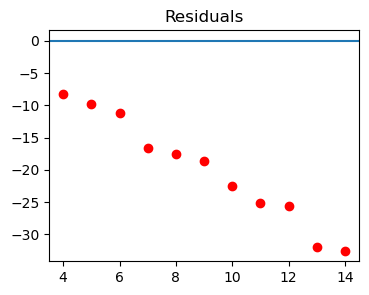



>>> Dataset II:


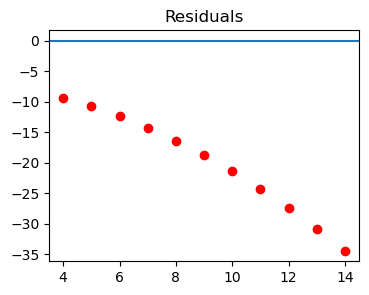



>>> Dataset III:


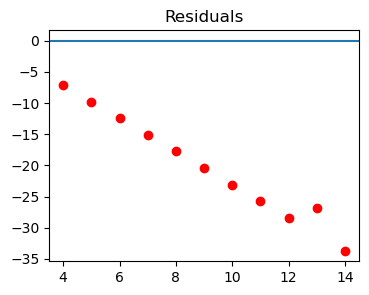



>>> Dataset IV:


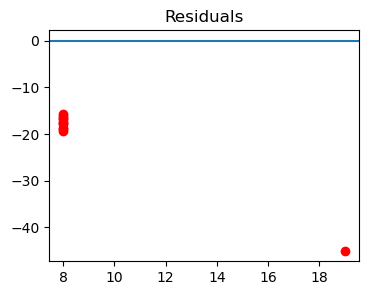

In [9]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize = RESID)
    plt.show(fig)
    print()
    print()

### Visualize the original data (what we should have done at the beginning)

>>> Dataset I:


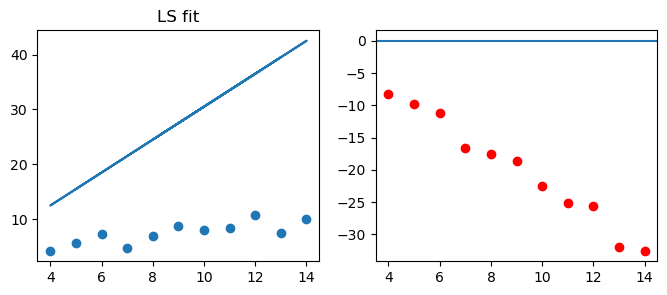



>>> Dataset II:


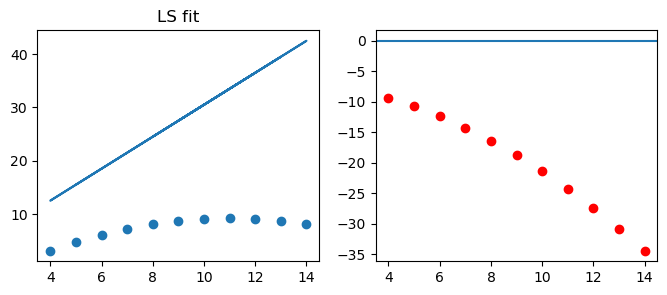



>>> Dataset III:


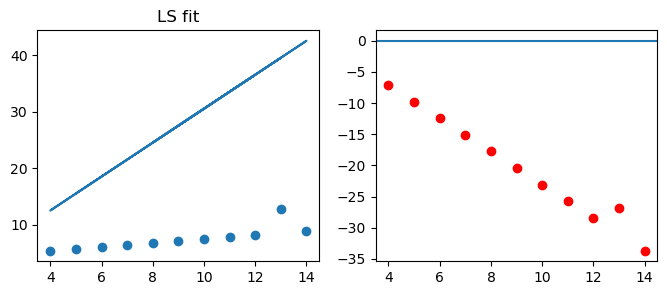



>>> Dataset IV:


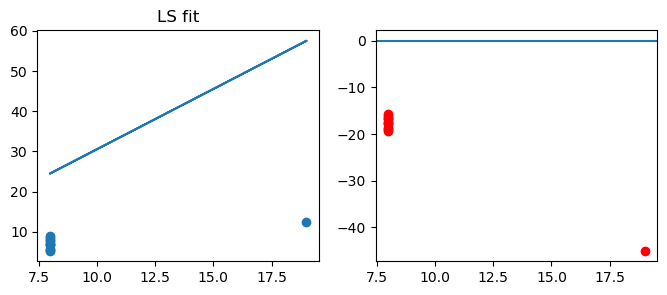

In [10]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize = RESID_SCATTER)
    plt.show(fig)
    print()
    print()